<a href="https://colab.research.google.com/github/sabrinabenb/Graph-Neural-Network-GNN/blob/main/GNNs_on_Planetoid_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial will show  how to apply Graph Neural Networks (GNNs) ,GCN,Graph SAGE, GAT, GCNv2 to the task of node classification. Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (transductive learning and  Inductive learning ).

For dataset , we make use of the Cora, Pubmed, Citesser dataset, which is a citation network

This code for GAT, you can simply exchange GAT with GCN or SAGE... .

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.3.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


import

In [ ]:
from typing import List, Optional, Tuple, Union

import torch.nn.functional as F
from torch import Tensor

from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size, SparseTensor
from torch_geometric.utils import spmm

In [ ]:
import os.path as osp
import time

import torch
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GraphSAGE


**Cora**

Change Cora by Pubmed or CiteSeer for other dataset in Planetoid dataset

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora',transform=T.NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
g = dataset[0] # Get the first graph object.
print(data)


Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
data = dataset[0]
g = dataset[0] # Get the first graph object.
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
from torch_geometric.nn import GCNConv,SAGEConv,GATConv
import torch.nn.functional as F
class net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads=8,dropout=0.6)
        self.conv2 = GATConv(hidden_channels*8, dataset.num_classes, heads=1,
                             concat=False, dropout=0.6)
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = net(hidden_channels=16)
print(model)

net(
  (conv1): GATConv(1433, 16, heads=8)
  (conv2): GATConv(128, 7, heads=1)
)


In [ ]:
import time

In [ ]:
model = net(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


times = []
for epoch in range(1, 101):
    start = time.time()
    loss = train()
    times.append(time.time() - start)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9307
Epoch: 003, Loss: 1.9203
Epoch: 004, Loss: 1.9095
Epoch: 005, Loss: 1.8841
Epoch: 006, Loss: 1.8558
Epoch: 007, Loss: 1.8413
Epoch: 008, Loss: 1.8174
Epoch: 009, Loss: 1.8086
Epoch: 010, Loss: 1.7563
Epoch: 011, Loss: 1.7312
Epoch: 012, Loss: 1.6934
Epoch: 013, Loss: 1.5930
Epoch: 014, Loss: 1.6242
Epoch: 015, Loss: 1.6045
Epoch: 016, Loss: 1.5723
Epoch: 017, Loss: 1.4894
Epoch: 018, Loss: 1.5193
Epoch: 019, Loss: 1.4127
Epoch: 020, Loss: 1.4898
Epoch: 021, Loss: 1.3620
Epoch: 022, Loss: 1.3648
Epoch: 023, Loss: 1.3441
Epoch: 024, Loss: 1.2673
Epoch: 025, Loss: 1.2977
Epoch: 026, Loss: 1.2404
Epoch: 027, Loss: 1.2252
Epoch: 028, Loss: 1.1697
Epoch: 029, Loss: 1.0852
Epoch: 030, Loss: 1.1026
Epoch: 031, Loss: 1.0660
Epoch: 032, Loss: 1.1204
Epoch: 033, Loss: 1.0274
Epoch: 034, Loss: 0.9723
Epoch: 035, Loss: 1.0170
Epoch: 036, Loss: 0.9837
Epoch: 037, Loss: 0.9743
Epoch: 038, Loss: 0.9313
Epoch: 039, Loss: 0.8959
Epoch: 040, Loss: 1.0369


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7010


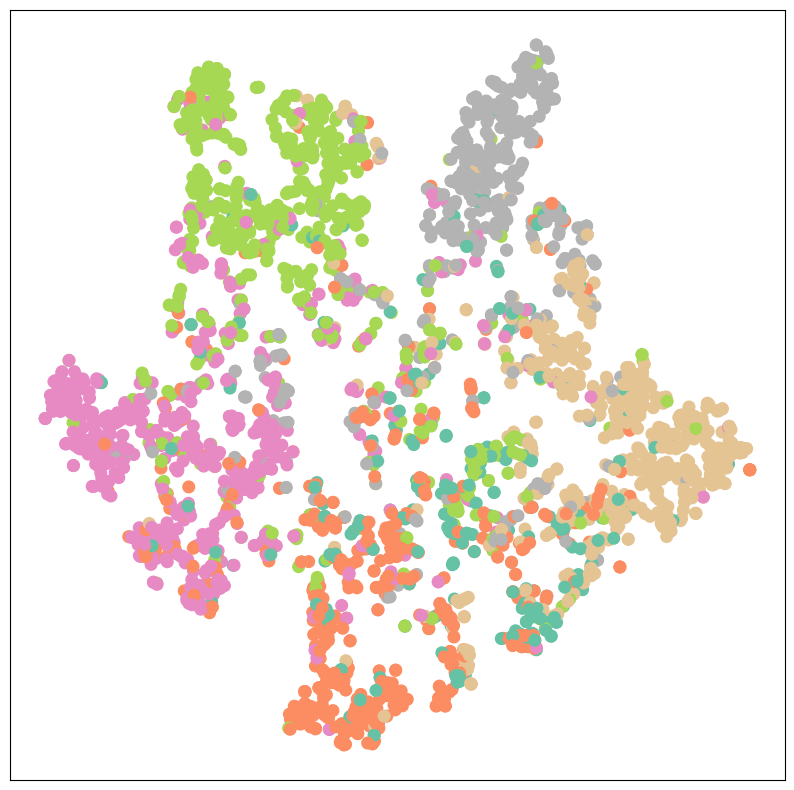

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)